In [1]:
import pandas as pd
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from statsmodels.formula.api import ols
from linearmodels.panel import PanelOLS


file_path = '/Users/rebeccluo/Downloads/US_Paid_leave_analysis.dta'

# Load the file into a DataFrame
df = pd.read_stata(file_path)
print(df.columns.tolist())

['ssuid', 'spanel', 'swave', 'srefmon', 'rhcalmn', 'rhcalyr', 'tfipsst', 'epppnum', 'esex', 'wpfinwgt', 'tage', 'eeducate', 'rmesr', 'birth_month', 'sippid', 'months', 'date', 'birth', 'birth_seen_f', 'birth_seen', 'ref_month_ns', 'ref_month', 'state', 'end_date', 'end_weight_f', 'end_weight', 'CA_date', 'NJ_date', 'post_policy', 'rm_lfp', 'working', 'looking', 'lt_college_f', 'lt_college', 'Birth', '_IBirth_2', '_IBirth_3', '_IBirth_4', '_IBirth_5', '_IBirth_6', '_IBirth_7', '_IBirth_8', '_IBirth_9', '_IBirth_10', '_IBirth_11', '_IBirth_12', '_IBirth_13', '_IBirth_14', '_IBirth_15', '_IBirth_16', '_IBirth_17', '_IBirth_18', '_IBirth_19', '_IBirth_20', '_IBirth_21', '_IBirth_22', '_IBirth_23', '_IBirth_24', '_IBirth_25', '_IBirth_26', '_IBirth_27', '_IBirth_28', '_IBirth_29', '_IBirth_30', '_IBirth_31', '_IBirth_32', '_IBirth_33', '_IBirth_34', '_IBirth_35', '_IBirth_36', '_IBirth_37', '_IBirth_38', '_IBirth_39', '_IBirth_40', '_IBirth_41', '_IBirth_42', '_IBirth_43', '_IBirth_44', '_I

In [2]:
unique_data = df.drop_duplicates(subset='sippid').dropna(subset=['rm_lfp'])
print(unique_data.shape)
birth_vars = [f'_IBirth_{i}' for i in range(2, 52)]  # Birth dummies from _IBirth_2 to _IBirth_51
birxpos_vars = [f'_IBirXpos_{i}_1' for i in range(2, 52)]  # Event-study dummies _IBirXpos_2_1 to _IBirXpos_50_1
llbirth_vars = [f'_LlBirth_{2}_1'] + [f'_LlBirth_{i}_1' for i in range(8, 51)]   # Reference period dummies from _LlBirth_8 to _LlBirth_50
llbipos_vars = [f'_LlBiXpos_{2}_1'] + [f'_LlBiXpos_{i}_1' for i in range(8, 51)]  # Event-study reference period _LlBiXpos_8_1 to _LlBiXpos_50_1, what we are interested in


(2816, 231)


In [3]:
import warnings

# Suppress all warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    year_dummies = pd.get_dummies(unique_data['rhcalyr'], drop_first=True)  # Time dummy for year
    birth_dummies = pd.get_dummies(unique_data[birth_vars], drop_first=False)  # Dummies for birth_vars
    state_dummies = pd.get_dummies(unique_data['state'], drop_first=True)  # Dummies for states (assuming 'state' column)
    sippid_dummies = pd.get_dummies(unique_data['sippid'], prefix='sippid', drop_first=True)
    month_dummies = pd.get_dummies(unique_data['ref_month'], prefix='month', drop_first=True)
    edu_dummies = pd.get_dummies(unique_data['lt_college'], prefix='college', drop_first=True)
    age_group_dummies = pd.get_dummies(unique_data['age_group'],prefix='age', drop_first=True)  # Dummies for age groups
    recession_dummies = pd.get_dummies(unique_data['recession_birth'],prefix='recession', drop_first=True)  # Dummies for recession years

    
    age_recession_interactions = pd.DataFrame(index=unique_data.index)
    for age_col in age_group_dummies.columns:
        for recession_col in recession_dummies.columns:
            interaction_name = f'{age_col}_recession_{recession_col}'
            age_recession_interactions[interaction_name] = age_group_dummies[age_col] * recession_dummies[recession_col]



    # Step 2: Create interaction terms between birth_vars and time (rhcalyr)
    birth_time_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{birth_col}_time_{year_col}'
            birth_time_interactions[interaction_name] = birth_dummies[birth_col] * year_dummies[year_col]

    # Step 3: Create interaction terms between birth_vars and state
    birth_state_interactions = pd.DataFrame(index=unique_data.index)
    for birth_col in birth_dummies.columns:
        for state_col in state_dummies.columns:
            interaction_name = f'{birth_col}_state_{state_col}'
            birth_state_interactions[interaction_name] = birth_dummies[birth_col] * state_dummies[state_col]



    state_year_interactions = pd.DataFrame(index=unique_data.index)
    for state_col in state_dummies.columns:
        for year_col in year_dummies.columns:
            interaction_name = f'{state_col}_time_{year_col}'
            state_year_interactions[interaction_name] = state_dummies[state_col] * year_dummies[year_col]


Training accuracy: 0.5319715808170515
Testing accuracy: 0.5390070921985816

Top 10 most important features:
                           feature  importance
0                      college_1.0    0.597205
1                       _IBirth_50    0.131593
2                       _IBirth_51    0.104339
3                          age_30s    0.096752
4                    recession_1.0    0.055747
5                             1996    0.010761
6  age_30s_recession_recession_1.0    0.003604
7                             2002    0.000000
8                        _IBirth_9    0.000000
9                        _IBirth_3    0.000000


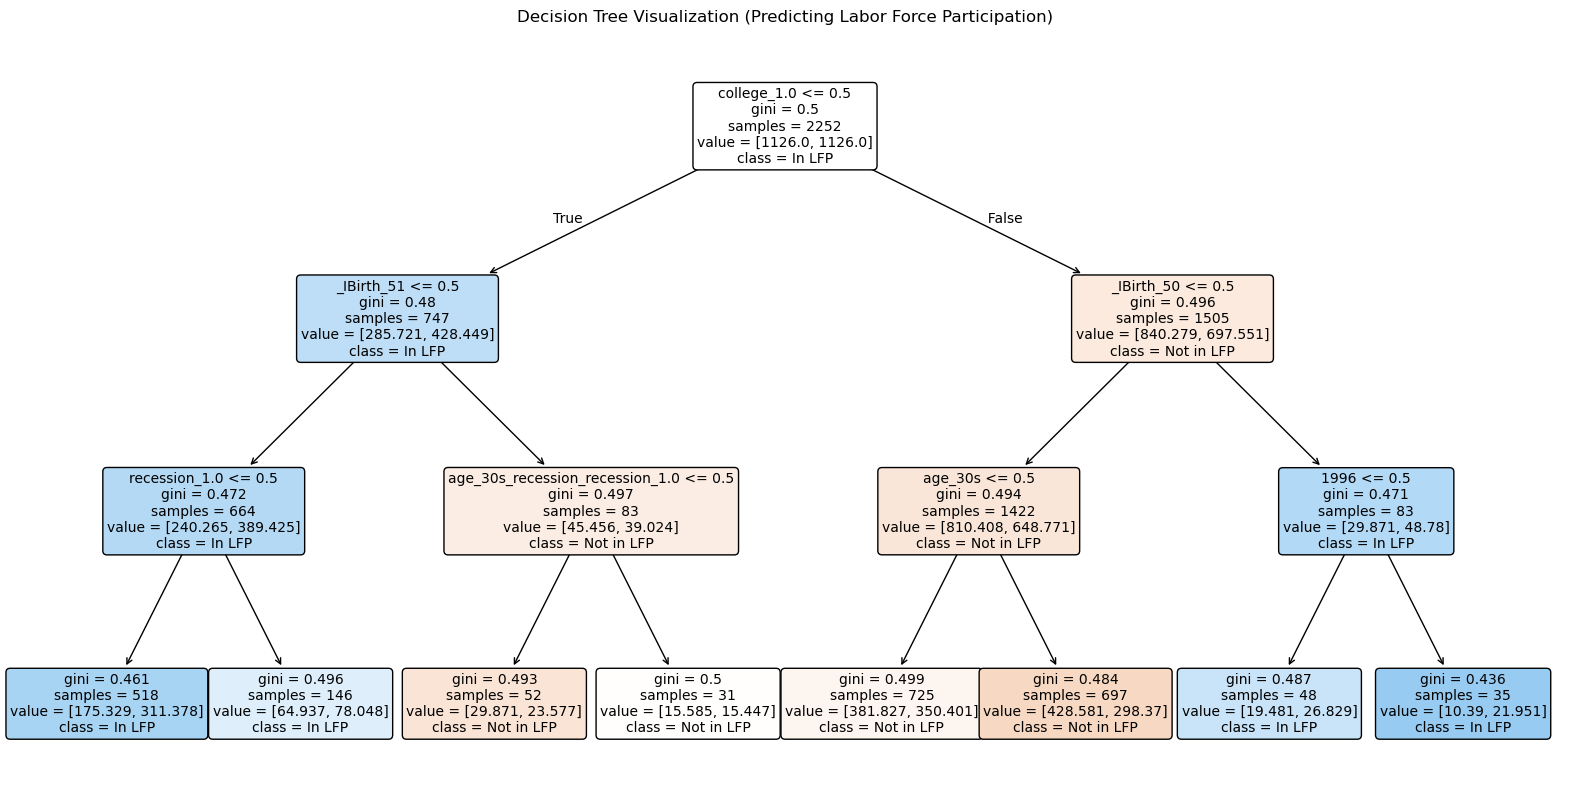


Main decision rules:
If college_1.0 <= 0.50:
    If _IBirth_51 <= 0.50:
    If recession_1.0 <= 0.50:
    Predict In LFP
else:
    Predict In LFP
else:
    If age_30s_recession_recession_1.0 <= 0.50:
    Predict Not in LFP
else:
    Predict Not in LFP
else:
    If _IBirth_50 <= 0.50:
    If age_30s <= 0.50:
    Predict Not in LFP
else:
    Predict Not in LFP
else:
    If 1996 <= 0.50:
    Predict In LFP
else:
    Predict In LFP

Cross-validation scores: [0.55319149 0.47069272 0.47246892 0.54884547 0.54351687]
Average CV score: 0.517743093609463


In [5]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

# Assuming unique_data['LFP'] is the binary target variable for labor force participation
# and unique_data['LFP'] is 0 for "Not in LFP" and 1 for "In LFP"
X = pd.concat([year_dummies,state_dummies,age_group_dummies,
    recession_dummies,age_recession_interactions,state_year_interactions,birth_dummies,edu_dummies], axis=1)

# Ensure no missing values (optional but helpful)
X = X.fillna(0)
X.columns = X.columns.astype(str)
y = unique_data['rm_lfp']  # Set the target to LFP

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create and train the decision tree
dt = DecisionTreeClassifier(
    max_depth=3,                # Limit tree depth to prevent overfitting
    min_samples_split=50,       # Minimum samples required to split a node
    min_samples_leaf=25,        # Minimum samples required at leaf node
    random_state=42,            # For reproducibility
    class_weight='balanced'     # Handle any class imbalance
)

# Fit the model
dt.fit(X_train, y_train)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
})

# Sort features by importance
feature_importance = feature_importance.sort_values(
    'importance', ascending=False
).reset_index(drop=True)

# Print model performance metrics
print("Training accuracy:", dt.score(X_train, y_train))
print("Testing accuracy:", dt.score(X_test, y_test))

# Print top 10 most important features
print("\nTop 10 most important features:")
print(feature_importance.head(10))

# Create visualization of the decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, 
          feature_names=X.columns,
          class_names=['Not in LFP', 'In LFP'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization (Predicting Labor Force Participation)")
plt.show()

# Function to get decision rules for top nodes
def get_decision_rules(tree, feature_names, class_names, node_id=0, depth=0):
    if tree.children_left[node_id] == -1:  # leaf node
        return f"Predict {class_names[np.argmax(tree.value[node_id])]}"
    
    feature = feature_names[tree.feature[node_id]]
    threshold = tree.threshold[node_id]
    
    left_rule = get_decision_rules(tree, feature_names, class_names, 
                                   tree.children_left[node_id], depth + 1)
    right_rule = get_decision_rules(tree, feature_names, class_names, 
                                    tree.children_right[node_id], depth + 1)
    
    return f"""If {feature} <= {threshold:.2f}:
    {left_rule}
else:
    {right_rule}"""

# Print decision rules for the first few levels
print("\nMain decision rules:")
print(get_decision_rules(dt.tree_, X.columns, ['Not in LFP', 'In LFP']))

# Add cross-validation score
cv_scores = cross_val_score(dt, X, y, cv=5)
print("\nCross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
